The measurement of the muon transverse momentum of muons is sensitive to several detector conditions:
   * the *alignment* of the tracker and of the muon chambers
   * the *composition and distribution of the material* inside the tracking volume
   * the knowledge of the *magnetic field* inside and outside the solenoid volume.
<br>

All these conditions affect differently the momentum measurement and can produce biases. In particular, the detector misalignment produces a relative bias that generally increases linearly with the momentum. For this reason it is extremely important to have an accurate knowledge of the tracker and muon spectrometer alignment, and a detailed mapping of the detector material and of the magnetic field. Residual biases can be corrected *a posteriori*, using calibration techniques that generally exploit data from very well-known processes, such as J/&psi;&rarr;&mu;&mu; or Z&rarr;&mu;&mu; decays.

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import ROOT

Welcome to JupyROOT 6.30/02


In [2]:
events = NanoEventsFactory.from_root(
    "/eos/uscms/store/user/cmsdas/2025/short_exercises/muons/DYJets.root", 
    schemaclass=NanoAODSchema,
    treepath = "Events",
).events()

In [3]:
muon=events.Muon

# Step 1: Generated and reconstructed dimuon Z mass
First, lets reconstruct dimuon z mass.
reapplying previous code. Using the following criteria to select two well-defined and isolated muons. For instance, you can require that both muons pass:<br>

* Muon_genPartIdx!=-1(each muon must have an associated generated particle)
* Muon_isGlobal==1
* Muon_pt>20.
* abs(Muon_eta)<2.4
* Muon_pfRelIso03_chg<0.15

In [4]:
muon_mask=(muon.genPartIdx!=-1)& (muon.isGlobal==1)& (muon.pt>20)& (abs(muon.eta)<2.4)& (muon.pfRelIso03_chg<0.15)

In [5]:
muons_good=muon[muon_mask]

We only keep events with 2 good muons. There are 6 events with over 2 muons, we will ignore them for simplicity.

In [6]:
two_good_muons=muons_good[ak.num(muons_good)==2]

In [7]:
two_good_muons.charge

<Array [[1, -1], [-1, 1], ... [-1, 1], [1, -1]] type='104665 * var * int32[param...'>

Lets make sure muons in eaach events have opposite charge

In [8]:
opposite_sign_muon_mask=(two_good_muons.charge[:,0]!=two_good_muons.charge[:,1])

In [9]:
two_opposite_good_muons=two_good_muons[opposite_sign_muon_mask]

In [10]:
dimuon_p4 = (two_opposite_good_muons[:, 0] + two_opposite_good_muons[:, 1])

In [11]:
print(dimuon_p4.mass)

[91.8, 88.2, 89.2, 90.4, 86.8, 84.8, 94.4, ... 91.2, 88.9, 93.5, 92.2, 83, 89.6]


We can further restrict the selection by requiring the invariant mass is between 70 and 110 GeV

In [12]:
dimuon_mass_mask=((dimuon_p4.mass>70)&(dimuon_p4.mass<110))

Text(0, 0.5, 'Events')

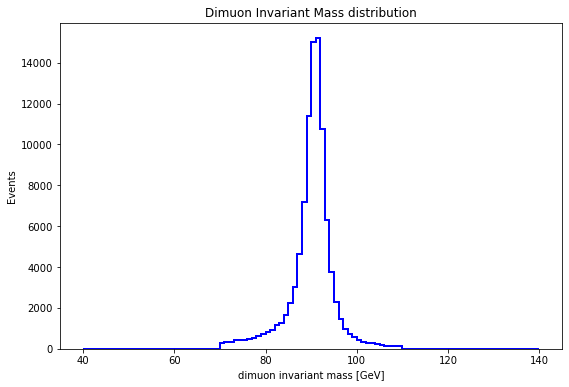

In [13]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4.mass[dimuon_mass_mask], bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

In [14]:
gen_muon=two_opposite_good_muons.matched_gen

In [15]:
gen_dimuon_p4=gen_muon[:,0]+gen_muon[:,1]
print(gen_dimuon_p4.mass)

[96, 87.2, 89.3, 90.4, 86.6, 89.9, 93.2, ... 91.9, 87.6, 93.4, 90.8, 82.4, 90.4]


Text(0, 0.5, 'Events')

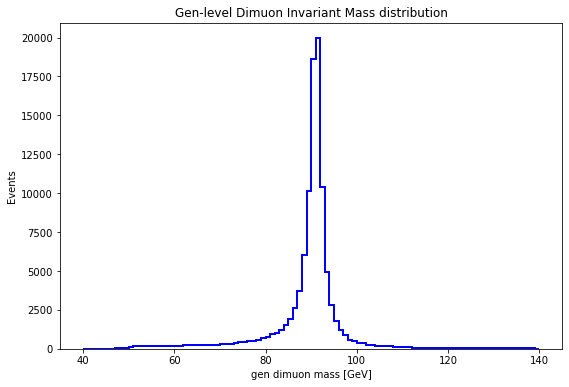

In [16]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
#plt.legend()
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

Then, we fit both generated and reconstructed Z mass.<br>
Keep in mind that the Z line shape is not Gaussian, so the Gaussian fit might not be perfect. We then fit them with more suitable functions for each case, e.g. a Breit-Wigner function for the generated mass and a Voigt function (i.e. a convolution of a Breit-Wigner with a Gaussian) for the reconstructed mass. You can easily do this from the ROOT e.g.:

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      472.908
NDf                       =           17
Edm                       =  2.29692e-06
NCalls                    =           96
p0                        =      48887.2   +/-   182.316     
p1                        =      90.9755   +/-   0.0065465   
p2                        =      2.85096   +/-   0.0170487   


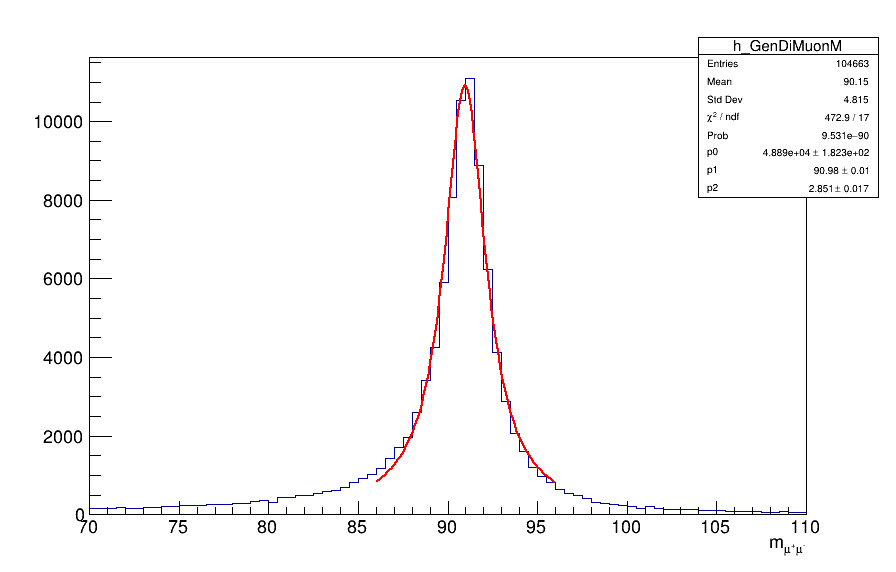

In [17]:
c1 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c1.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c1.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      127.029
NDf                       =           16
Edm                       =  3.97986e-07
NCalls                    =          226
p0                        =        50675   +/-   298.138     
p1                        =      90.8757   +/-   0.00935092  
p2                        =     0.847912   +/-   0.0495074   
p3                        =      3.45267   +/-   0.0747883   


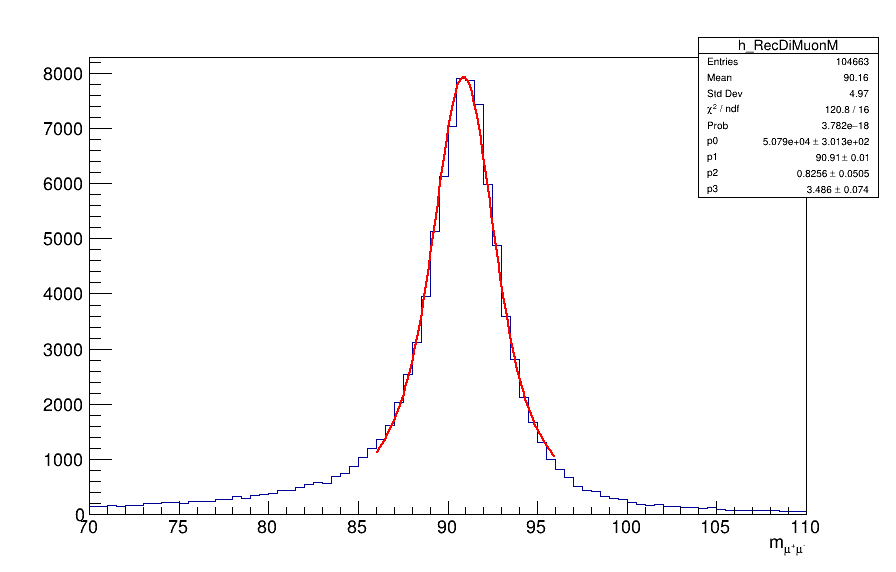

In [18]:
c2 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in dimuon_p4.mass:
    h_RecDiMuonM.Fill(m)
h_RecDiMuonM.Draw()
c2.Draw()
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c2.Draw()
#h_RecDiMuonM.Fit("gaus","","", 86., 96.)

**Questions 1:**
   * Compare the mean values obtained from the fits to the generated and reconstructed distributions. Are they compatible or do they differ significantly? How do they compare to the nominal Z mass value, m<sub>Z</sub> = 91.1876 GeV? Which distribution has the larger shift with respect to m<sub>Z</sub>?
   * Compare the widths of the two distributions (GEN and RECO). Which one is larger? Can you explain why? 
   * Considering that the natural width of the Z boson is &Gamma;<sub>Z</sub> = 2.4952 GeV, can you roughly estimate the typical dimuon mass resolution of Z&rarr;&mu;&mu; events measured with the CMS detector?(*Note:* with a _Voigtian_ fit, you would get an estimate of the  mass resolution directly from the fit) 
   * Why do you need different functions to better fit the generated and reconstructed mass distributions? What differs between the two? If you had to fit the peak of a reconstructed J/&psi; instead, what function would you use, and why?



**Answers 1:**

- Both distributions show mean values slightly lower than the nomimal Z mass. The reconstructed mass distribution has a mean that differs more from the nomimal value than the generator level one, indicating a slight bias in the reconstructed muon momentum
- The reconstructed mass distribution has a larger width, as the mass values are smeared by the detector resolution in this case
- As the total resolution is given by the addition in quadrature of the intrinsic width the detector resolution, we can estimate the contribution of the detector to the total width as (&sigma;<sub>total</sub>**2 - &Gamma;<sub>Z</sub>**2 )**0.5 , which comes out to roughly 2.4 GeV in this case. Normalized to the Z boson mass, this gives a resolution of roughly 2.5%
-  The generated mass distribution is given just by the instrinsic shape of the Z boson decay, which follows a Breit-Wigner distribution. The reconstructed mass distibution is smeared by the detector resolution, which is a Gaussian. Therefore, it can be fitted by a Voigtian, which is a convolution of the Breit-Wigner with a Gaussian distribution. In the case of the J/&psi;, the instrinsic width is negliglible and the peak can be fitted with a simple Gaussian. Note that in practice often other distribution, such as Crystal Ball, are used to take into account also non-Gaussian effects. 

# Step 2: Investigate the muon transverse momentum resolution

Now we will study the muon transverse momentum resolution. We will consider distributions of the transverse momentum residuals, defined as  R(1/pT) = (1/pT<sup>REC</sup> &ndash; 1/pT<sup>GEN</sup>)/(1/pT<sup>GEN</sup>). In the ideal case, the distribution of the residuals is expected to be Gaussian and its standard deviation is the pT resolution. Likewise, we can define the dimuon invariant mass residuals as R(M) = (M<sup>REC</sup> &ndash; M<sup>GEN</sup>)/M<sup>GEN</sup>, and the standard deviation of the R(M) distribution defines the mass resolution. 

We will first study R(1/PT):
   * 1D histogram of the muon transverse momentum residuals R(1/PT): A histogram (h_MupTRes) of the muon transverse momentum residual using the PAT muons and GEN muons. 
   * Fit this distribution to a Gaussian function. 
   * The fit parameter sigma gives the muon transverse momentum resolution in the chosen p<sub>T</sub> range.

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      10303.1
NDf                       =           77
Edm                       =  6.17218e-09
NCalls                    =           80
Constant                  =      25032.5   +/-   80.7025     
Mean                      =   0.00034381   +/-   3.55548e-05 
Sigma                     =    0.0158505   +/-   3.67077e-05  	 (limited)


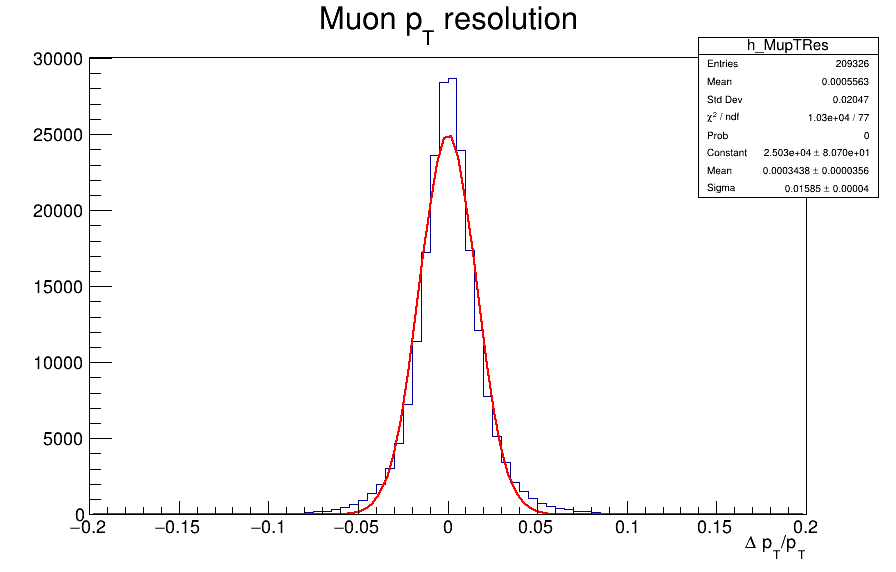

In [19]:
pt_res=ak.flatten(two_opposite_good_muons.matched_gen.pt)/ak.flatten(two_opposite_good_muons.pt)-1

c6 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c6.Draw()
h_MupTRes.Fit("gaus", "s")



Let's now study the dimuon invariant mass residual R(M), with a similar procedure as above:
  * Make a 1D histogram of the dimuon invariant mass residuals R(M): A histogram (h_MassRes) for the invariant mass resolution residual, which is defined as (M<sub>rec</sub> - M<sub>gen</sub> )/M<sub>gen</sub>. 
  * Fit this distribution to a Gaussian.
    
### Fill in the code below to plot and fit the distribution
* define R(M) as a variable called `mass_res`
* add a line in for loop to fill the histogram
* add a line at the end of the cell to fit the distribution to a Gaussian

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      3489.66
NDf                       =           73
Edm                       =  4.66237e-06
NCalls                    =           67
Constant                  =      12325.5   +/-   53.7356     
Mean                      = -0.000339239   +/-   3.86003e-05 
Sigma                     =    0.0122757   +/-   3.70616e-05  	 (limited)


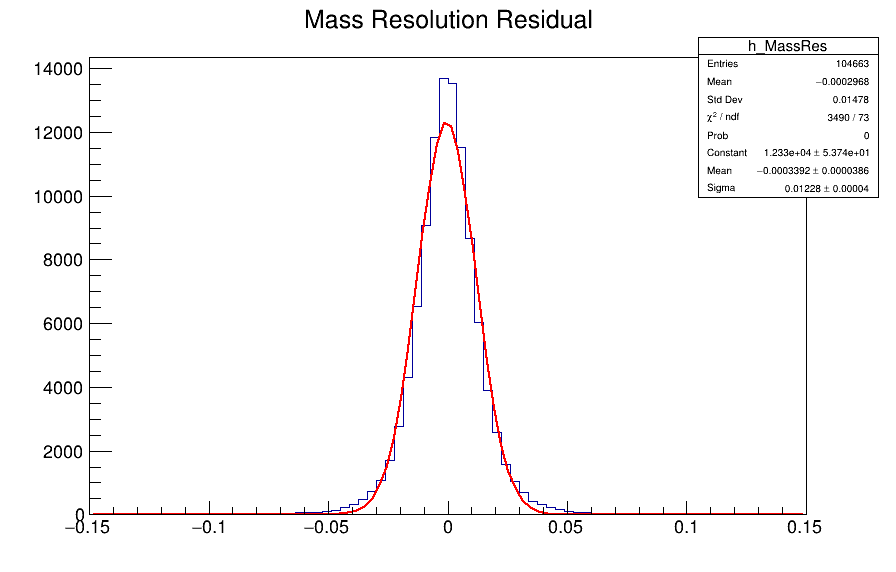

In [20]:
mass_res=dimuon_p4.mass/gen_dimuon_p4.mass-1

c7 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    h_MassRes.Fill(res)
h_MassRes.Draw()
c7.Draw()
h_MassRes.Fit("gaus", "s")

We will make a [TProfile histograms](http://root.cern.ch/root/html/TProfile.html) (prof_MupTvspTRes and prof_MuEtavspTRes) of muon transverse momentum residuals  as a function of muon pT and &eta;.
Note that, by default, a [TProfile](http://root.cern.ch/root/html/TProfile.html) will display in each bin the <span style='color:red'> mean value $\pm$ mean value error </span> (i.e. RMS/$\sqrt(N)$). Initializing the [TProfile](http://root.cern.ch/root/html/TProfile.html)  with option "s" instead, it will display <span style='color:red'> mean value $\pm$ RMS </span>. This is more useful for us, as the RMS estimates the standard deviation, i.e. the resolution of each bin. 

Let's first plot the muon pT residual as a function of eta:

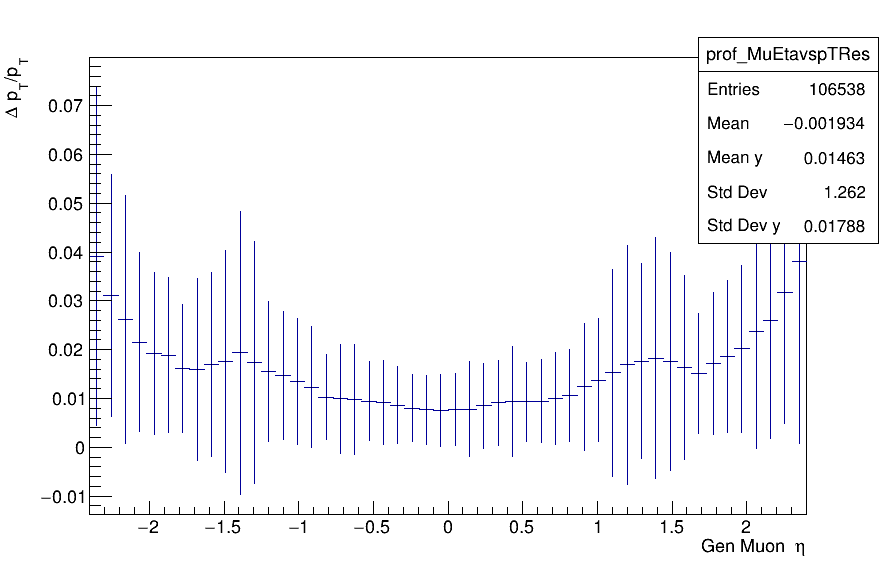

In [21]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1,'s')
for ptres, eta in zip(pt_res, ak.flatten(two_opposite_good_muons.matched_gen.eta)):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c8 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c8.Draw()

Now can you plot the muon pT residual as a function of pT?

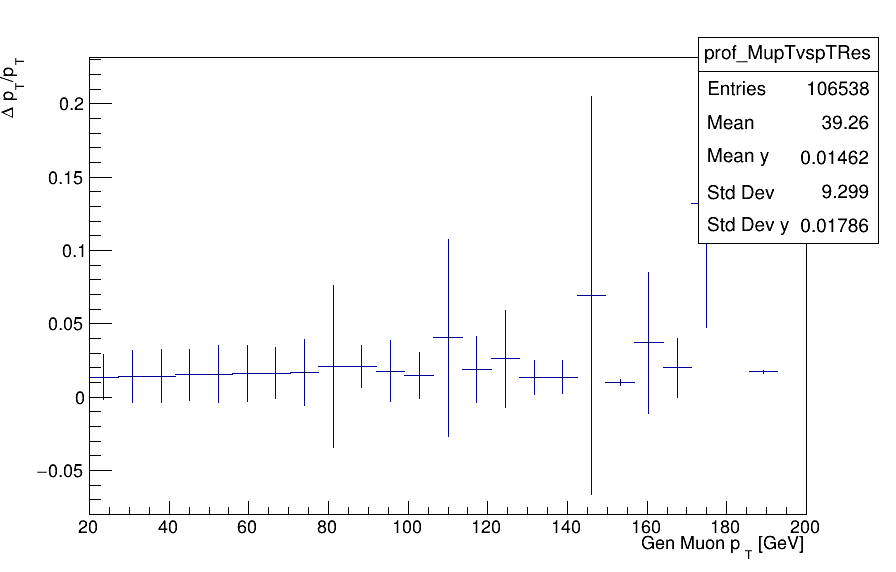

In [22]:
prof_MupTvspTRes = ROOT.TProfile("prof_MupTvspTRes",";Gen Muon p_{T} [GeV];#Delta p_{T}/p_{T}",25,20,200,0,1,'s')
for ptres, pt in zip(pt_res, ak.flatten(two_opposite_good_muons.matched_gen.pt)):
    prof_MupTvspTRes.Fill(pt, ptres, 1)
c9 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c9.Draw()

**Questions 2**:
* What is the typical 1/pT resolution of a 50 GeV muon measured in the CMS detector?
* How does the 1/pT resolution scale with transverse momentum? And with the pseudorapidity?
* Why is the mass residual not a perfect Gaussian distribution?
* How is the 1/pT resolution related to the invariant mass resolution?

**Answers 2:**
- About 1.5%
- The 1/pT resolution slowly increases with higher pT as the muon tracks become more straight and their curvature is less easily measured. The resolution is best for central muons and degrades towards higher |eta| due to the inhomogenous magnetic field and higher particle rates in the forward region.
- There are non-Gaussian effects, such as energy loss due to bremsstrahlung radiation from the outgoing muons.
- The mass resolution is directly given by the resolution of the two muons that are reconstructed to find the dimuon system. 

# Step 3: Momentum scale corrections

As mentioned in the introduction, small biases in the muon momentum measurement can be recovered by applying specific corrections. In CMS we have several algorithms to compute such corrections to the momentum scale and/or resolution. They are documented in this MUO POG [TWiki page](https://twiki.cern.ch/twiki/bin/view/CMS/MuonReferenceScaleResolRun2). In the following, we will demonstrate the use of one of these correction strategies, called _Rochester algorithm_. The details of the algorithm and how it computes the corrections are beyond the goals of this exercise. Suffice it to say that it extracts correction factors by "forcing" muons from (mostly) Z&rarr;&mu;&mu; decays to coincide with reference distributions obtained from Monte Carlo generated muons. For more details, check out  [EPJC V72, 10.2194 (2012)](https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-012-2194-8) [arXiv:1208.3710](https://arxiv.org/abs/1208.3710) or the link above.


Since Run 3, the corrections are provided in JSON format that can be read with the correctionlib package. Code to calculate the corrected pT vaues for invidivual muons based on these corrections is also provided by Muon POG on [gitlab](https://gitlab.cern.ch/cms-muonPOG/muonscarekit/-/tree/master?ref_type=heads). This will be moved to central repositories maintained by CAT and XPOG in the future.  

In [23]:
from MuonScaRe import pt_resol, pt_scale
import correctionlib

In [24]:
cset = correctionlib.CorrectionSet.from_file("2022_schemaV2.json")

print (cset.get("cb_params").evaluate(1.3, 8., 0))

#For MC, we need to apply both scale and resolution correction. We apply scale corrections first
two_opposite_good_muons["pt_scalecorr"] = pt_scale(0, two_opposite_good_muons.pt, two_opposite_good_muons.eta, two_opposite_good_muons.phi, two_opposite_good_muons.charge, "nom", cset)
#Next, we apply resolution corrections using the scale-corrected pT values as input
two_opposite_good_muons["pt_fullcorr"] = pt_resol(two_opposite_good_muons.pt_scalecorr, two_opposite_good_muons.eta, two_opposite_good_muons.nTrackerLayers, "nom", cset)

0.011189300393776816


In [25]:
from coffea.nanoevents.methods import candidate
muonCorrected = ak.zip({
            "pt": two_opposite_good_muons.pt_fullcorr,
            "eta": two_opposite_good_muons.eta,
            "phi": two_opposite_good_muons.phi,
            "mass": two_opposite_good_muons.mass,
            "charge": two_opposite_good_muons.charge,
            "isolation": two_opposite_good_muons.pfRelIso03_all,
        }, with_name="PtEtaPhiMCandidate", behavior=candidate.behavior)


In [26]:
dimuon_p4_corr=muonCorrected[:,0]+muonCorrected[:,1]

In [27]:
dimuon_mass_mask=(dimuon_p4_corr.mass>70)&(dimuon_p4_corr.mass<110)

Text(0, 0.5, 'Events')

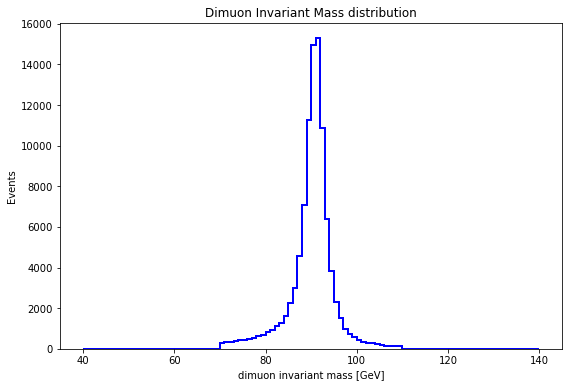

In [28]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4_corr.mass[dimuon_mass_mask], bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

Text(0, 0.5, 'Events')

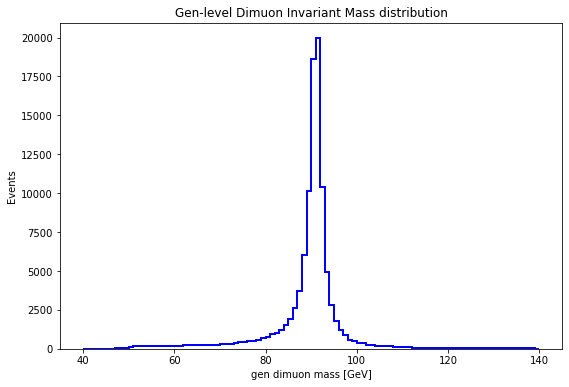

In [29]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
#plt.legend()
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

In [30]:
c10 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c10.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c10.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      472.908
NDf                       =           17
Edm                       =  2.29692e-06
NCalls                    =           96
p0                        =      48887.2   +/-   182.316     
p1                        =      90.9755   +/-   0.0065465   
p2                        =      2.85096   +/-   0.0170487   


Warning in <TCanvas::Constructor>: Deleting canvas with same name: gendimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_GenDiMuonM (Potential memory leak).


In [31]:
c11 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in dimuon_p4_corr.mass:
    h_RecDiMuonM.Fill(m)
h_RecDiMuonM.Draw()
c11.Draw()
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c11.Draw()
#h_RecDiMuonM.Fit("gaus","","", 86., 96.)

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      120.843
NDf                       =           16
Edm                       =  7.56486e-10
NCalls                    =          263
p0                        =        50790   +/-   301.296     
p1                        =      90.9066   +/-   0.00949117  
p2                        =     0.825583   +/-   0.050522    
p3                        =      3.48558   +/-   0.074308    


Warning in <TCanvas::Constructor>: Deleting canvas with same name: recdimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_RecDiMuonM (Potential memory leak).


Text(0, 0.5, 'Events')

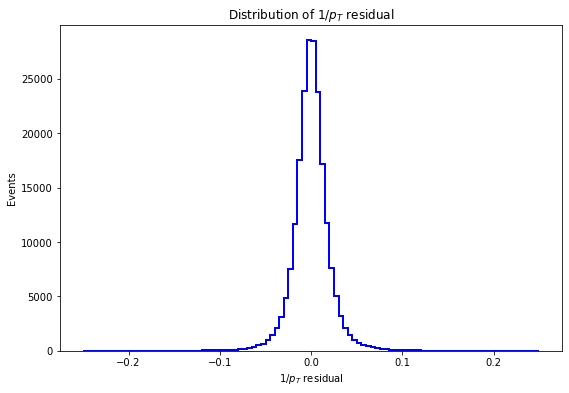

In [32]:
pt_res=ak.flatten(two_opposite_good_muons.matched_gen.pt)/ak.flatten(two_opposite_good_muons.pt_fullcorr)-1
plt.figure(figsize=(9,6))
plt.hist(pt_res, bins=100, range=[-0.25,0.25], histtype='step',linewidth=2, color='blue', label='$1/p_T$ residual')
#plt.legend()
plt.title('Distribution of $1/p_T$ residual')
plt.xlabel('$1/p_T$ residual')
plt.ylabel('Events')

In [33]:
mass_res=dimuon_p4_corr.mass/gen_dimuon_p4.mass-1

Text(0, 0.5, 'Events')

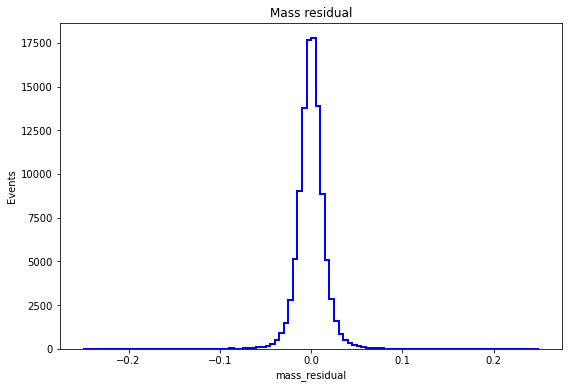

In [34]:
plt.figure(figsize=(9,6))
plt.hist(mass_res, bins=100, range=[-0.25,0.25], histtype='step', linewidth=2, color='blue', label='mass_residual')
#plt.legend()
plt.title('Mass residual')
plt.xlabel('mass_residual')
plt.ylabel('Events')

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      10236.4
NDf                       =           77
Edm                       =  1.18788e-07
NCalls                    =           71
Constant                  =      25048.4   +/-   80.6984     
Mean                      =  4.07957e-05   +/-   3.55266e-05 
Sigma                     =    0.0158457   +/-   3.66537e-05  	 (limited)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: ptresidual
Warning in <TROOT::Append>: Replacing existing TH1: h_MupTRes (Potential memory leak).
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error i

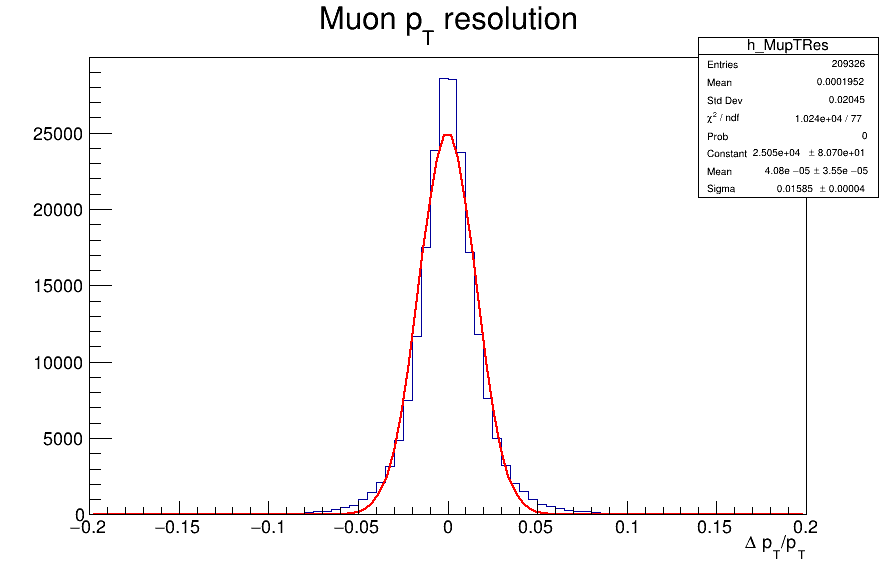

In [35]:
c16 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c16.Draw()
h_MupTRes.Fit("gaus")

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      3510.56
NDf                       =           75
Edm                       =  4.72918e-06
NCalls                    =           67
Constant                  =      12334.6   +/-   53.7852     
Mean                      = -8.99469e-06   +/-   3.85724e-05 
Sigma                     =    0.0122642   +/-   3.70371e-05  	 (limited)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: massresidual
Warning in <TROOT::Append>: Replacing existing TH1: h_MassRes (Potential memory leak).
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error

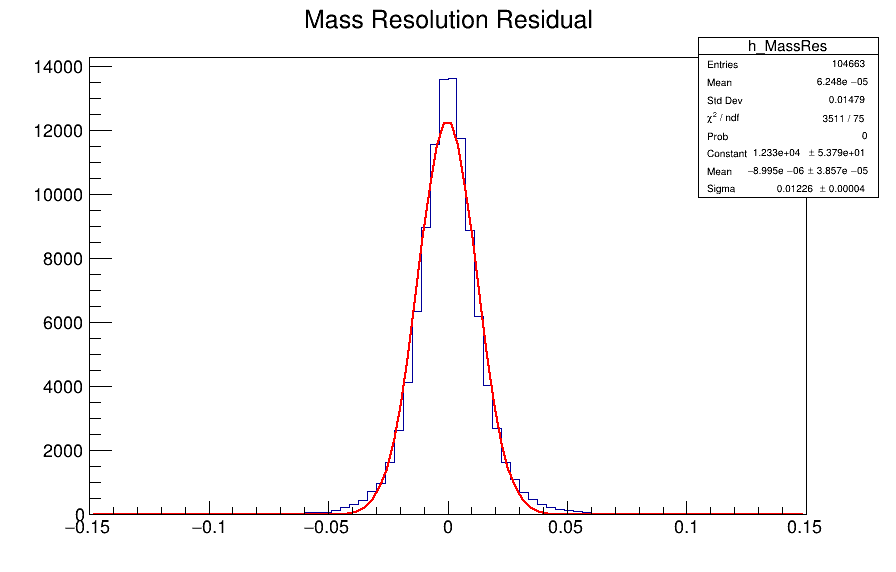

In [36]:
c17 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    h_MassRes.Fill(res)
h_MassRes.Draw()
c17.Draw()
h_MassRes.Fit("gaus")

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuEtavspTRes (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: muetavsptres


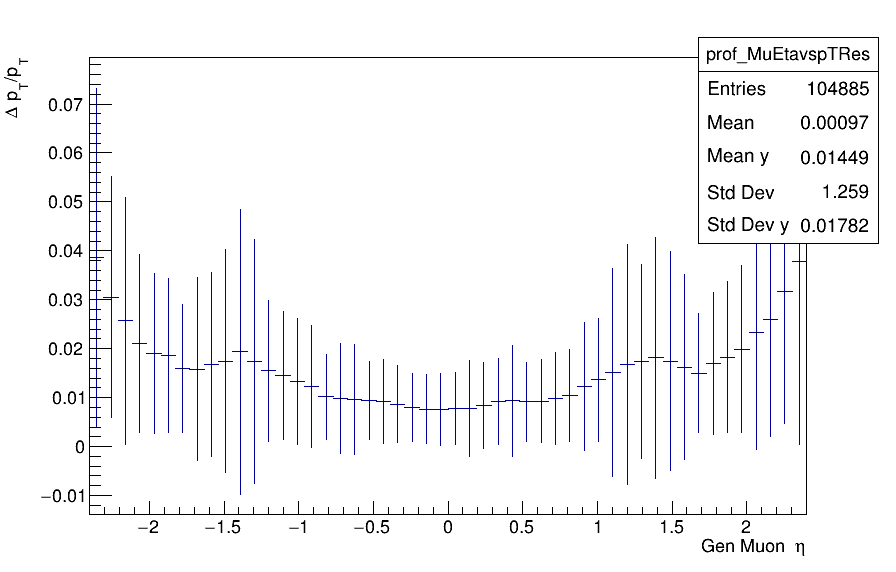

In [37]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1,'s')
for ptres, eta in zip(pt_res, ak.flatten(two_opposite_good_muons.matched_gen.eta)):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c18 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c18.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: prof_MupTvspTRes (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: muptvsptres


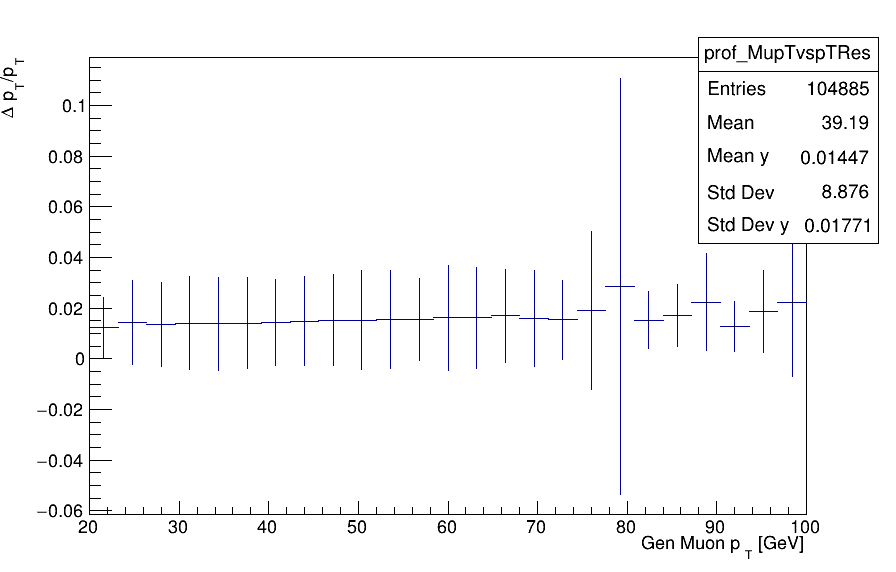

In [38]:
prof_MupTvspTRes = ROOT.TProfile("prof_MupTvspTRes",";Gen Muon p_{T} [GeV];#Delta p_{T}/p_{T}",25,20,100,0,1,'s')
for ptres, pt in zip(pt_res, ak.flatten(two_opposite_good_muons.matched_gen.pt)):
    prof_MupTvspTRes.Fill(pt, ptres, 1)
c19 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c19.Draw()

**Questions 3:**
   * Describe the main differences that you observe between the uncorrected and corrected distributions. 
   * Does the corrected mass spectrum get closer to the generated mass spectrum, and the peak closer to the PDG value? 
   * How did the resolution change after the corrections? How would you explain it? 

**Answers 3:**
- In general, there are only small differences. This is because we applied the correction to the MC, where biases are small. Much larger effects are seen on data.
- The peak value is closer to PDG value. The overall mass spectrum is not that much closer overall as the correction can't undo the detector resolution.
- The resolution got a little worse, as the goal is to match the resolution in data, which is generally worse than the one in simulation. 